In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix, csr_array

#Import Standard Random Walks
from polytopewalk.dense import BallWalk, HitAndRun

#Import Barrier Random Walks
from polytopewalk.dense import DikinWalk, VaidyaWalk, JohnWalk, DikinLSWalk

#Import Initialization Algorithm
from polytopewalk.dense import DenseCenter

#Import Facial Reduction Algorithm 
from polytopewalk import FacialReduction

#Import End-to-End Pipeline
from polytopewalk import denseFullWalkRun

In [2]:
#Simplex to sample from 
def generate_birkhoff(dim):
    d = int(math.floor(np.sqrt(dim)))
    k = d*d
    A = lil_matrix((2 * d - 1, d**2))
    b = np.ones(2 * d - 1)

    for i in range(1, d + 1):
        A[i - 1, (i - 1) * d : i * d] = 1
    for i in range(1, d):
        A[d + i - 1, i - 1 : d**2 : d] = 1
    
    x = np.ones(d*d)/d
    return x, A, b, k, 'birkhoff'

def generate_simplex(d):
    return np.array([1/d] * d), np.array([[1] * d]), np.array([1]), d, 'simplex'

def generate_hc(dim):
    dim = dim // 3
    col = np.concatenate((np.arange(0, dim), np.arange(0, dim), np.arange(dim, 3 * dim)))
    row = np.concatenate((np.arange(0, 2 * dim), np.arange(0, 2 * dim)))
    ones = np.ones(dim)
    negative_ones = np.repeat(-1, dim)
    data = np.concatenate((ones, negative_ones, ones, ones))
    A = sparse.csr_array((data, (row, col)), shape = (2 * dim, 3 * dim))
    b = np.array([[1]] * (2 * dim))
    x = np.concatenate((np.array([[0]] * (dim)), np.array([[1]] * (2 * dim))))
    return x, A, b, 2 * dim, 'hypercube'

In [3]:
#Initialize Barrier Walks, r = radius of ellipsoid, thin = which sample you keep
THIN, ITER, BURNIN = 10, 10_000, 1_000
dikin = DikinWalk(r = 0.8, thin = THIN)
vaidya = VaidyaWalk(r = 0.8, thin = THIN)
john = JohnWalk(r = 0.8, thin = THIN)

In [4]:
#Initialize Polytope in Full-Dimensional Form

fr = FacialReduction()
_, A, b, k, name = generate_simplex(5)

polytope = fr.reduce(A, b, k, sparse = False)
dense_A = polytope.dense_A
dense_b = polytope.dense_b

dc = DenseCenter()
init = dc.getInitialPoint(dense_A, dense_b)

In [5]:
#Generate 10,000 points with a initial burn in of 10,000 steps
dikin_res = dikin.generateCompleteWalk(ITER, init, dense_A, dense_b, burn = BURNIN)
vaidya_res = vaidya.generateCompleteWalk(ITER, init, dense_A, dense_b, burn = BURNIN)
john_res = john.generateCompleteWalk(ITER, init, dense_A, dense_b, burn = BURNIN)

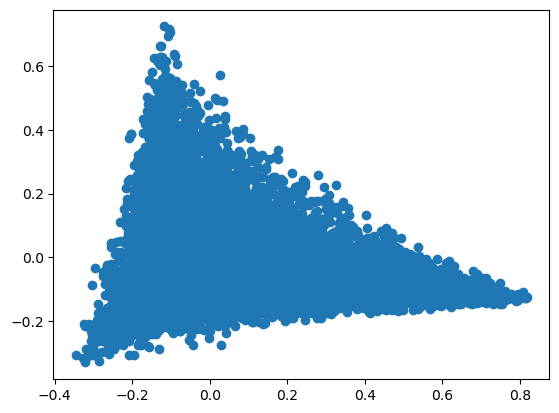

In [6]:
#Plot 2 dimensions of Dikin Walk
plt.scatter(dikin_res[:, 0], dikin_res[:, 1])

In [ ]:
#Does Facial Reduction & Converts back to Higher Dimension
walk_res = denseFullWalkRun(ITER, A, b, k, dikin, fr, dc)

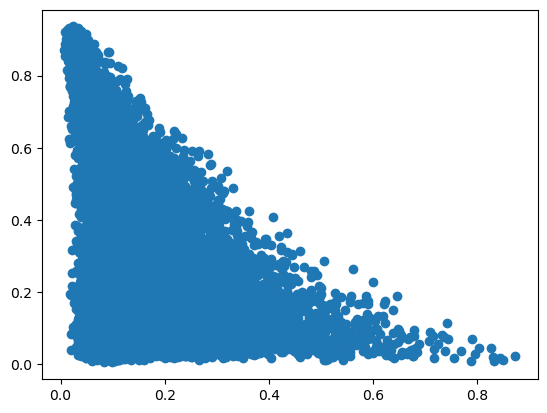

In [8]:
plt.scatter(walk_res[:, 0], walk_res[:, 1])
plt.show()

In [ ]:
#Example code to sample from a netlib lp polytope
#Warning: reaching stationarity will take longer steps for the higher-dimensional polytope

dikin = DikinWalk(r = 1e-3, thin = THIN)

polytope = pd.read_pickle('data/ADLITTLE.pkl')
A = polytope['sparse_A']
b = polytope['sparse_b']
k = polytope['k']

walk_res = denseFullWalkRun(ITER, A, b, k, dikin, fr, dc)